# Leios simulation analysis at tag `leios-2025w30`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: mini-mainnet vs pseudo-mainnet

In [2]:
label <- "Rust simulator, mini-mainnet, 100 tx/s, 1400 B/tx"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(lifecycle, sampleSize, file="results/lifecycle.R")
}
lifecycle[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator                         Variant             Stage length  
 Rust:89982   linear-with-tx-references:89982   5 slot/stage :    0  
                                                8 slot/stage :89982  
                                                15 slot/stage:    0  
                                                                     
                                                                     
                                                                     
                                                                     
     Max EB size           Network      Kind            Item      
 10.0 MB/EB:89982   topology-v1:44800   EB:   72   0      :    2  
 50.0 MB/EB:    0   topology-v2:45182   RB:   72   1      :    2  
 20.0 MB/EB:    0                       TX:89838   10     :    2  
 5.0 MB/EB :    0                                  100    :    2  
 2.0 MB/EB :    0                                  1000   :    2  
 1.0 MB/EB :    0                     

#### Range of transaction injection

In [4]:
txFirst <- 0
txLast <- 450
txWindow <- txLast - txFirst
simFinish <- 900

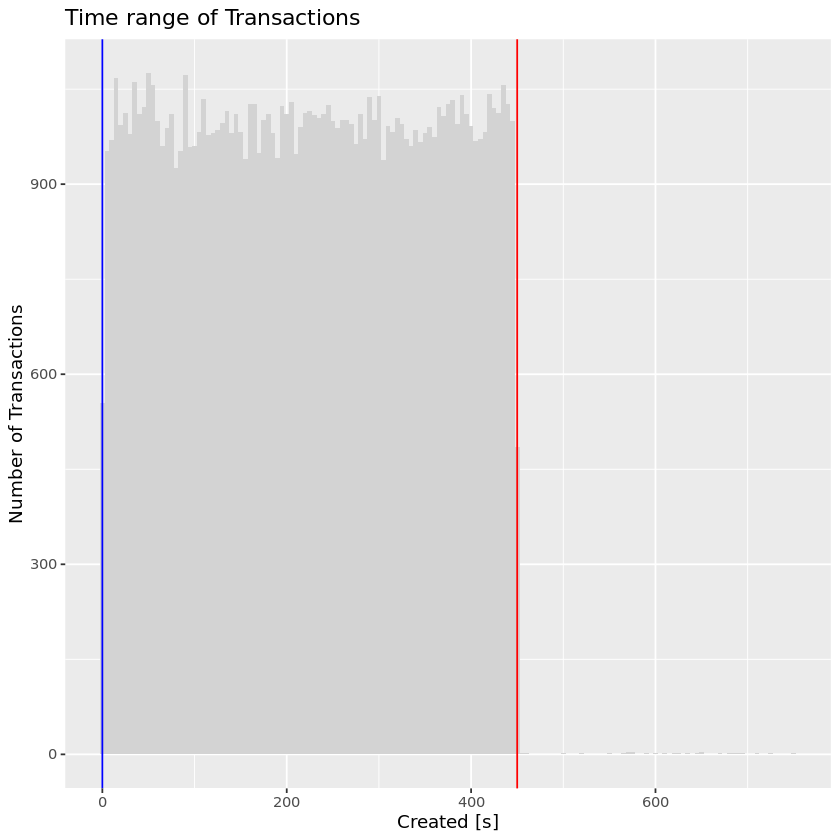

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [Mb/s]`=8*sum(`Size [B]`)/1e6/txWindow,
        `Time to full EB [s]`=1/(sum(`Size [B]`)/(1e6*as.numeric(substring(`Max EB size`, 1, 4)))/txWindow),
        `Transaction size [B/tx]`=sum(`Size [B]`)/.N
    ),
    .(`Variant`, `Stage length`, `Max EB size`, `Network`)
][order(`Variant`, `Stage length`, - `Max EB size`, `Network`)]

Variant,Stage length,Max EB size,Network,Demand [tx/s],Demand [MB/s],Demand [Mb/s],Time to full EB [s],Transaction size [B/tx]
<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
linear-with-tx-references,8 slot/stage,10.0 MB/EB,topology-v1,99.38222,0.1391351,1.113081,71.87258,1400
linear-with-tx-references,8 slot/stage,10.0 MB/EB,topology-v2,100.25778,0.1403609,1.122887,71.24492,1400


#### Size of persisted data

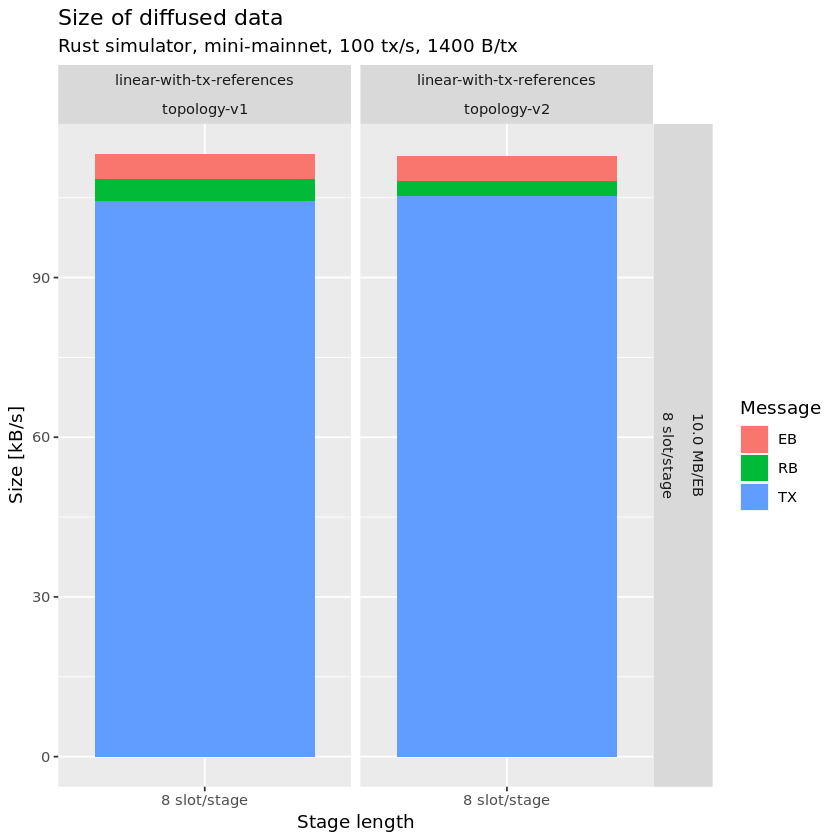

In [7]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        .(`Variant`, `Message`=`Kind`, `Stage length`, `Max EB size`, `Network`)
    ],
    aes(x=`Stage length`, y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales="free_y") +
    ggtitle("Size of diffused data", subtitle=label)

In [8]:
ggsave("plots/sizes.png", units="in", dpi=150, width=16, height=8)

#### Spatial efficiency

In [9]:
lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Stage length`, `Max EB size`, `Network`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Variant` != "linear" & `Kind` == "TX" | `Kind` == "EB" | `Kind` == "RB") * `Size [B]`))), 
            .(`Variant`, `Stage length`, `Max EB size`, `Network`)
        ],
        on=c("Variant", "Stage length", "Max EB size", "Network")
    ][, .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)][order(`Variant`, `Stage length`, -`Max EB size`, `Network`)]

Variant,Stage length,Max EB size,Network,Space efficiency [%]
<fct>,<fct>,<fct>,<fct>,<dbl>
linear-with-tx-references,8 slot/stage,10.0 MB/EB,topology-v1,92.18654
linear-with-tx-references,8 slot/stage,10.0 MB/EB,topology-v2,93.21921


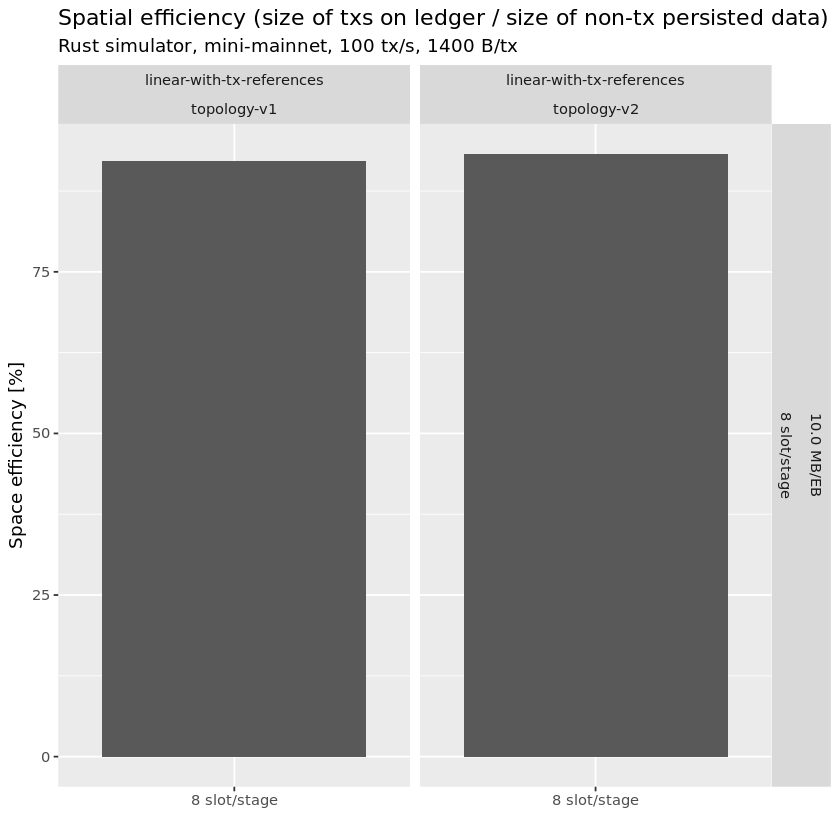

In [10]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Stage length`, `Max EB size`, `Network`)
    ][
        lifecycle[
            `Kind` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Variant` != "linear" & `Kind` == "TX" | `Kind` == "EB" | `Kind` == "RB") * `Size [B]`))), 
            .(`Variant`, `Stage length`, `Max EB size`, `Network`)
        ],
        on=c("Variant", "Stage length", "Max EB size", "Network")
    ][, .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Stage length`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    xlab("") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [11]:
ggsave("plots/spatial-efficiency.png", units="in", dpi=150, width=16, height=8)

#### Time to reach the EB

In [12]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`, `Network`)
    ][order(`Variant`, `Stage length`, -`Max EB size`, `Network`)]

Variant,Stage length,Max EB size,Network,Time to reach EB [s]
<fct>,<fct>,<fct>,<fct>,<dbl>
linear-with-tx-references,8 slot/stage,10.0 MB/EB,topology-v1,13.42811
linear-with-tx-references,8 slot/stage,10.0 MB/EB,topology-v2,26.61991


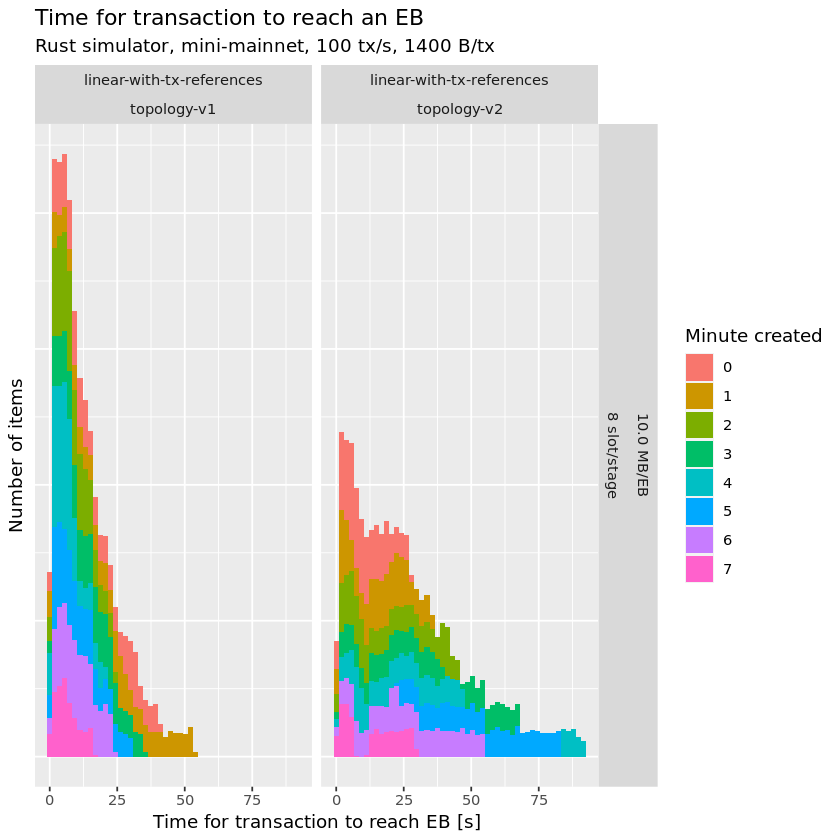

In [13]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
#   scale_x_log10() +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales="free_y") +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [14]:
ggsave("plots/reach-eb-tx.png", units="in", dpi=150, width=16, height=8)

#### Time to reach the ledger

In [15]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`, `Network`)
    ][order(`Variant`, `Stage length`, -`Max EB size`, `Network`)]

Variant,Stage length,Max EB size,Network,Time to reach ledger [s]
<fct>,<fct>,<fct>,<fct>,<dbl>
linear-with-tx-references,8 slot/stage,10.0 MB/EB,topology-v1,46.93607
linear-with-tx-references,8 slot/stage,10.0 MB/EB,topology-v2,77.86673


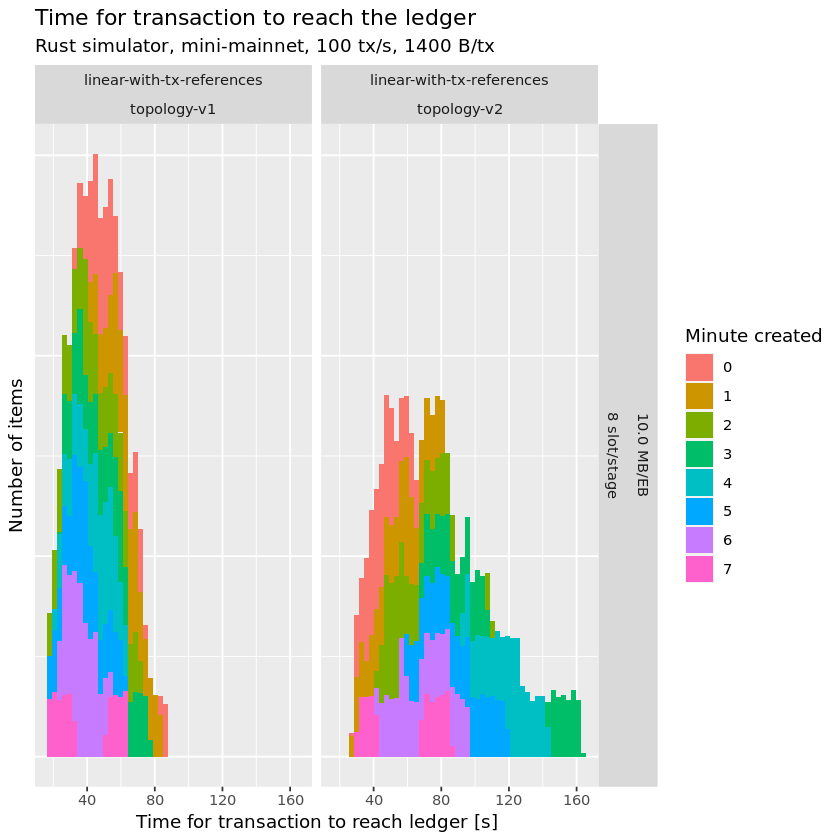

In [16]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Variant`, `Kind`, `Stage length`, `Max EB size`, `Network`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
#   scale_x_log10() +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [17]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=16, height=8)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

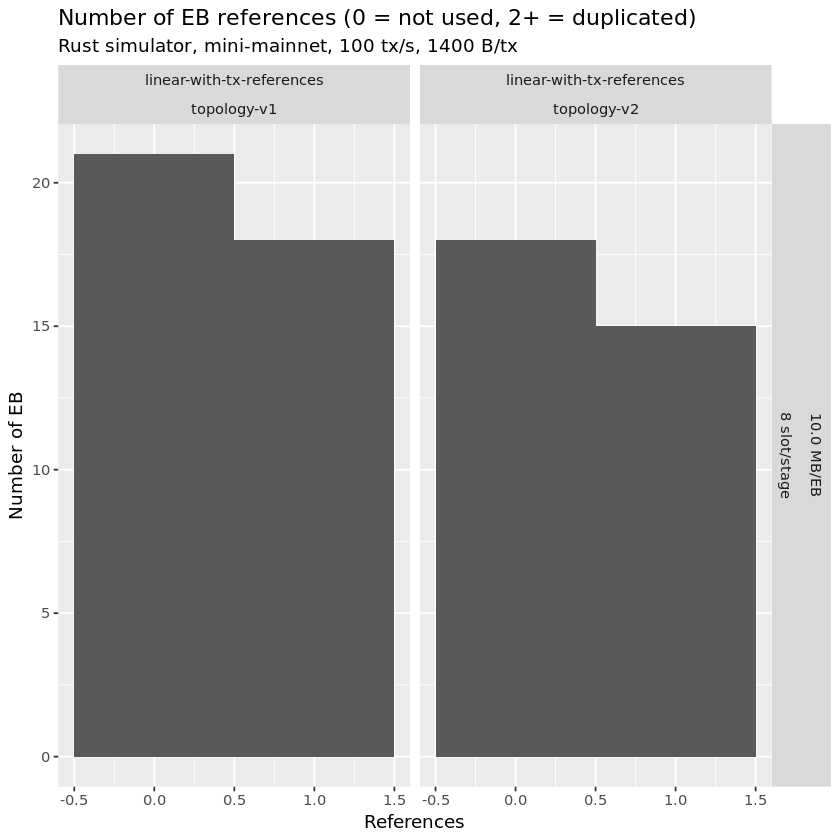

In [18]:
ggplot(
    lifecycle[
        `Kind` == "EB",
        .(`References`),
        .(`Variant`, `Stage length`, `Max EB size`, `Network`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales="free_y") +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [19]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

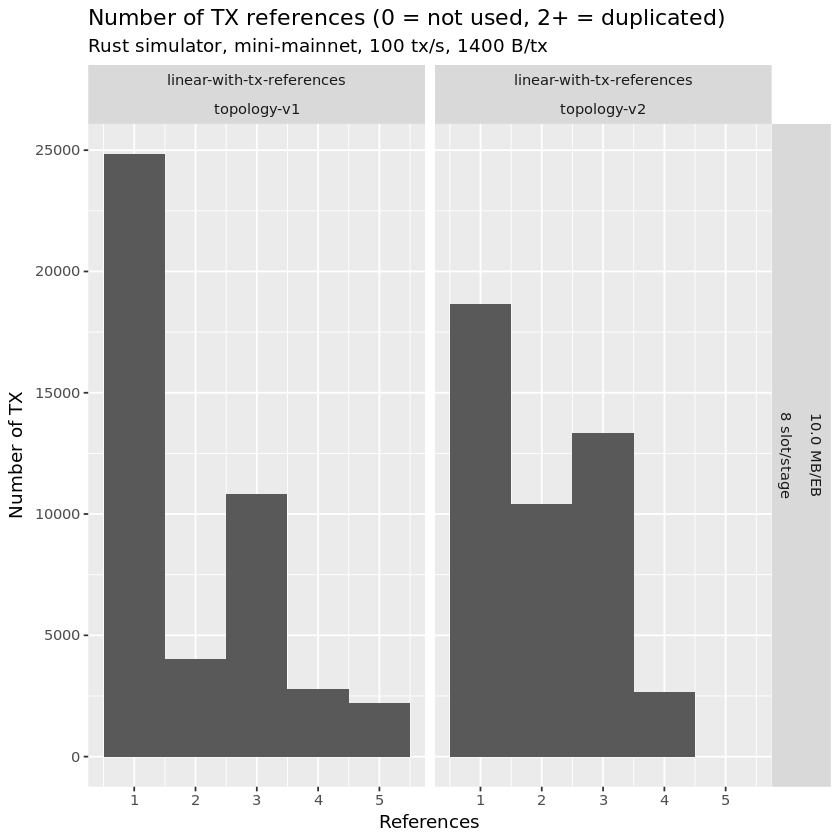

In [20]:
ggplot(
    lifecycle[
        `Kind` == "TX",
        .(`References`),
        .(`Variant`, `Stage length`, `Max EB size`, `Network`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales="free_y") +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [21]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

#### Temporal efficiency

In [22]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [23]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Variant`, `Stage length`, `Max EB size`, `Network`
    )
][order(`Variant`, `Stage length`, `Max EB size`, `Network`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [24]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Submitted [minute]`)]

#### Transactions reaching the ledger

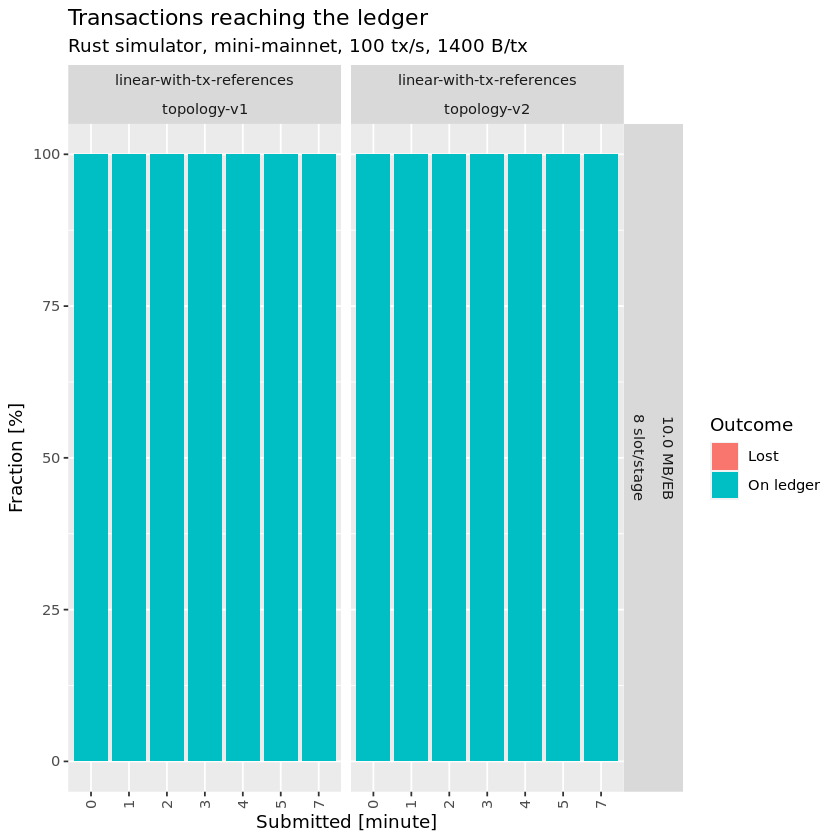

In [25]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Submitted [minute]`)],
        id.vars=c("Variant", "Stage length", "Max EB size", "Network", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[`Submitted [minute]` != 6, .(
        `Variant`,
        `Stage length`, 
        `Max EB size`,
        `Network`,
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [26]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=16, height=8)

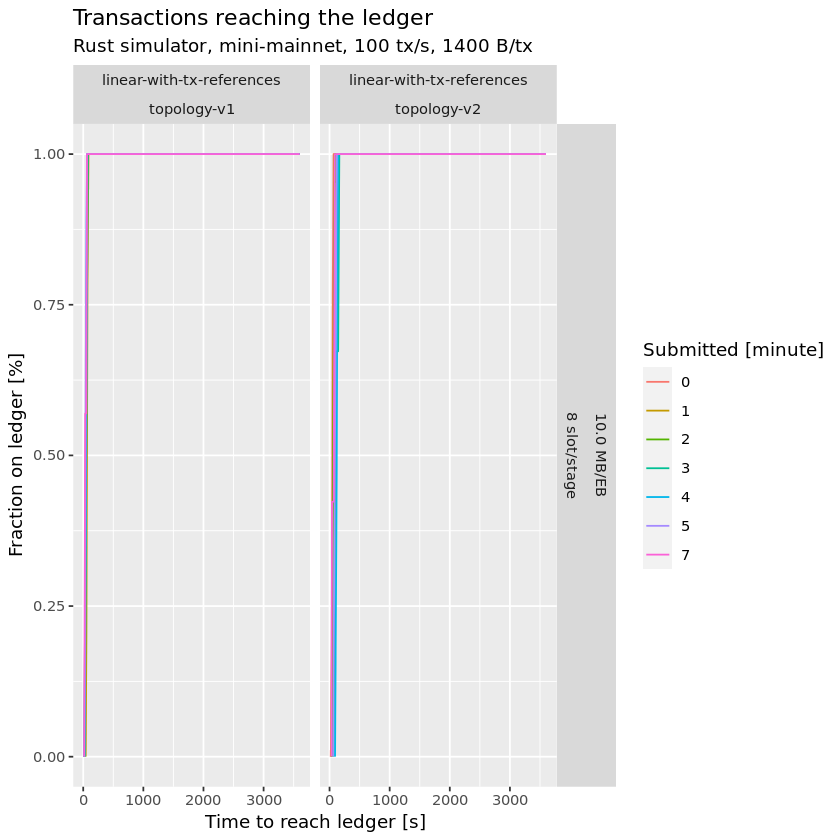

In [27]:
ggplot(
    rbind(
        totals[
            outcomes[
                !is.na(`Time to reach ledger [s]`), 
                .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), 
                .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Submitted [minute]`)
            ],
            on=c("Variant", "Stage length", "Max EB size", "Network", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 6],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ggtitle("Transactions reaching the ledger", label)

In [28]:
ggsave("plots/temporal-efficiency-timeseries.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [29]:
rm(lifecycle, outcomes, totals)

In [30]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,967765,51.7,2036090,108.8,2036090,108.8
Vcells,2121642,16.2,10161269,77.6,9785750,74.7


### Resource usage

In [31]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(resources, file="results/resources.Rdata")
}
resources[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
resources %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator                         Variant             Stage length  
 Rust:10750   linear-with-tx-references:10750   5 slot/stage :    0  
                                                8 slot/stage :10750  
                                                15 slot/stage:    0  
                                                                     
                                                                     
                                                                     
                                                                     
     Max EB size           Network            Node         Egress [B]       
 10.0 MB/EB:10750   topology-v1:10000   node-0  :    2   Min.   :0.000e+00  
 50.0 MB/EB:    0   topology-v2:  750   node-1  :    2   1st Qu.:4.376e+06  
 20.0 MB/EB:    0                       node-10 :    2   Median :3.367e+07  
 5.0 MB/EB :    0                       node-100:    2   Mean   :6.646e+07  
 2.0 MB/EB :    0                       node-101:    2 

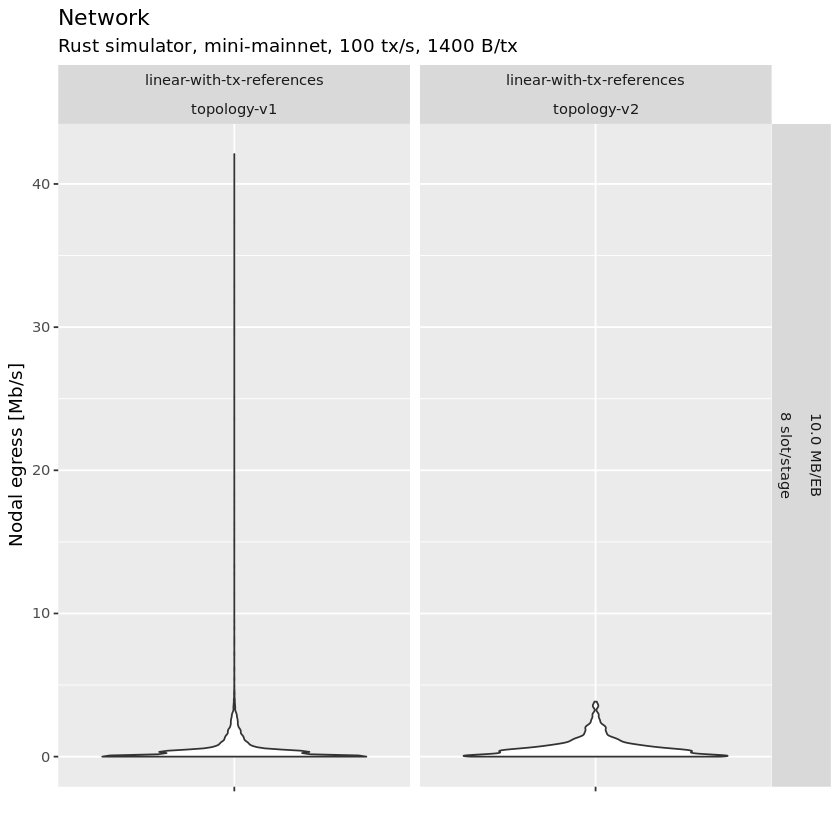

In [32]:
ggplot(
    resources[, .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales="free_y") +
    xlab("") +
    ggtitle("Network", label)

In [33]:
ggsave("plots/network.png", units="in", dpi=150, width=16, height=8)

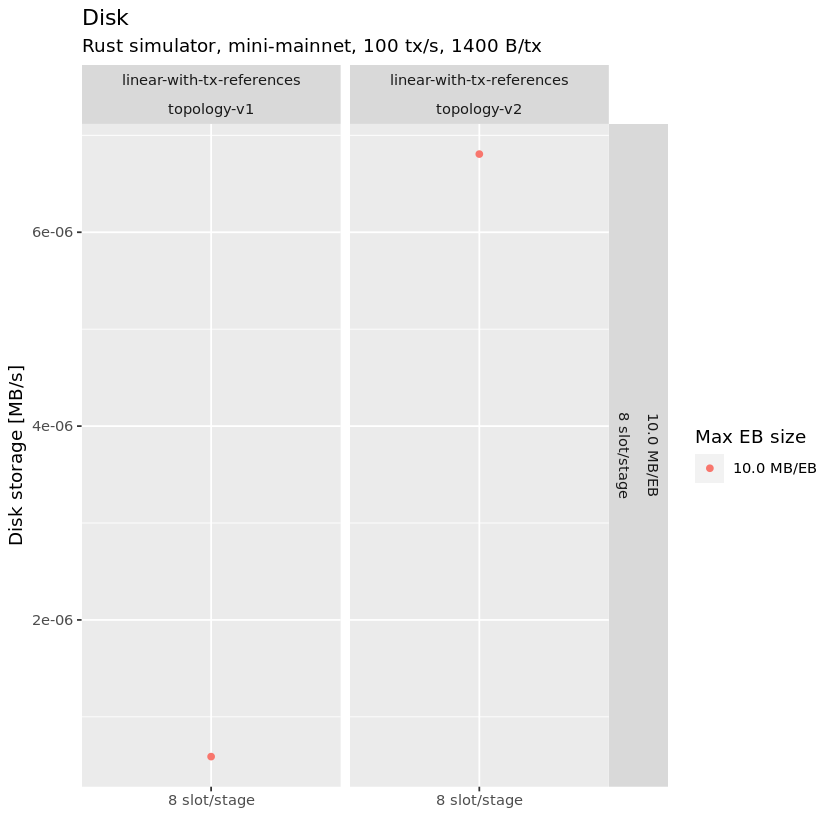

In [34]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Variant`, `Stage length`, `Max EB size`, `Network`)],
    aes(x=`Stage length`, color=`Max EB size`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    xlab("") +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ggtitle("Disk", label)

In [35]:
ggsave("plots/disk.png", units="in", dpi=150, width=16, height=8)

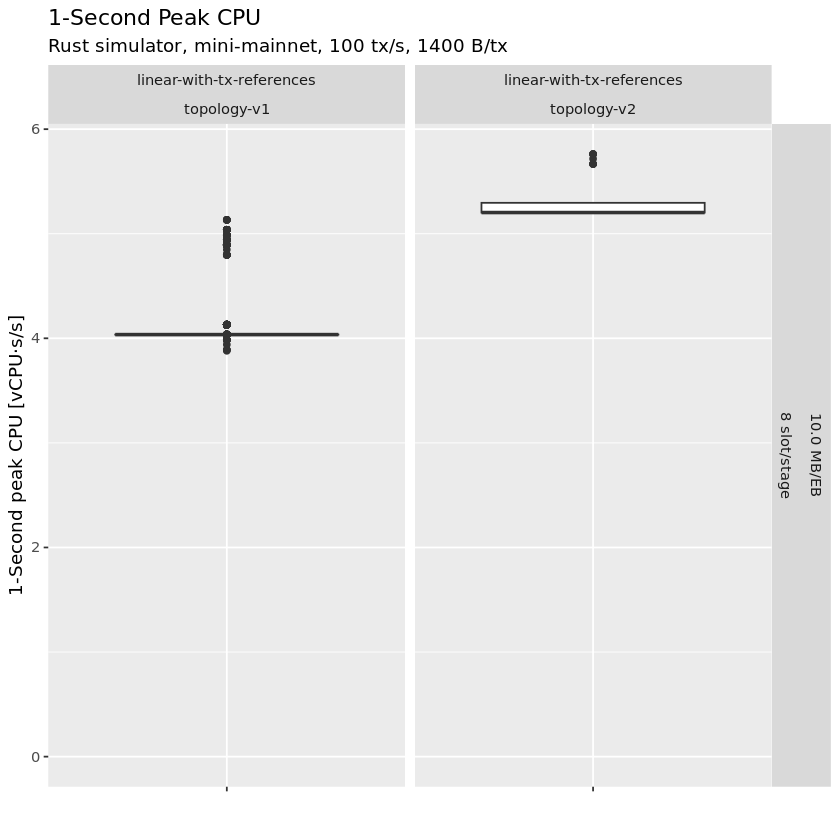

In [36]:
ggplot(
    resources[, .(`Node`, `Variant`, `Stage length`, `Max EB size`, `Network`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [37]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=16, height=8)

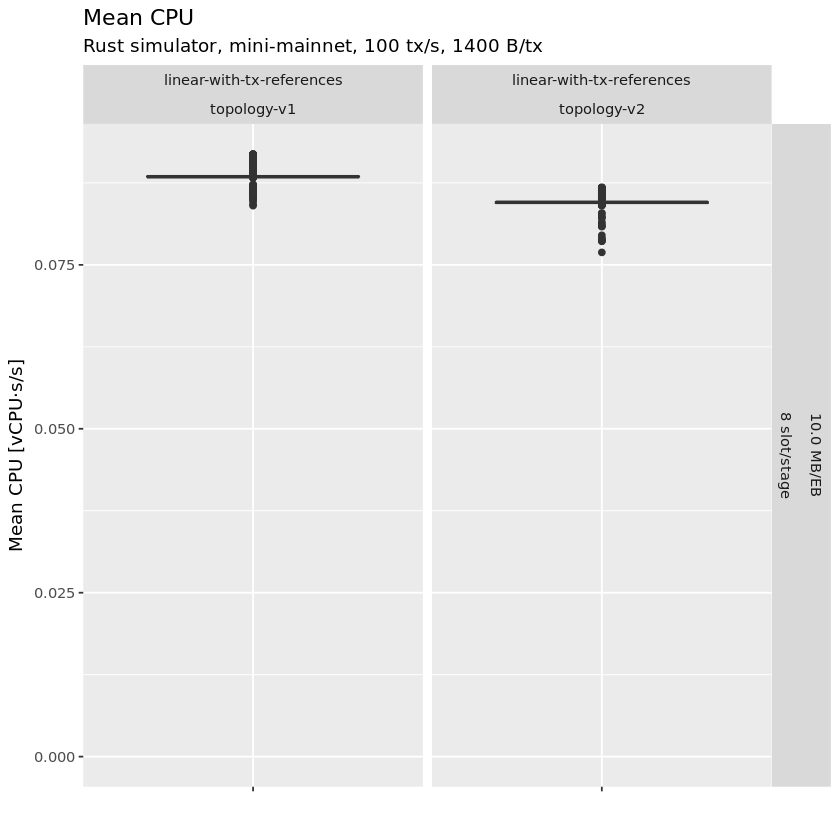

In [38]:
ggplot(
    resources[, .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [39]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [40]:
rm(resources)

In [41]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1007151,53.8,2036090,108.8,2036090,108.8
Vcells,1889893,14.5,10161269,77.6,9785750,74.7


### Receipt of messages

#### Read results

In [42]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(receipts, file="results/receipts.Rdata")
}
receipts[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
receipts %>% summary

Loaded Rdata file: sampleSize = 0.2 


 Simulator                             Variant         
 Rust:120364067   linear-with-tx-references:120364067  
                                                       
                                                       
                                                       
                                                       
                                                       
                                                       
        Stage length           Max EB size               Network         
 5 slot/stage :        0   10.0 MB/EB:120364067   topology-v1:112698448  
 8 slot/stage :120364067   50.0 MB/EB:        0   topology-v2:  7665619  
 15 slot/stage:        0   20.0 MB/EB:        0                          
                           5.0 MB/EB :        0                          
                           2.0 MB/EB :        0                          
                           1.0 MB/EB :        0                          
                           (Other)

In [43]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [44]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        rs[, .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_wrap(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales=scales, ncol=2) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

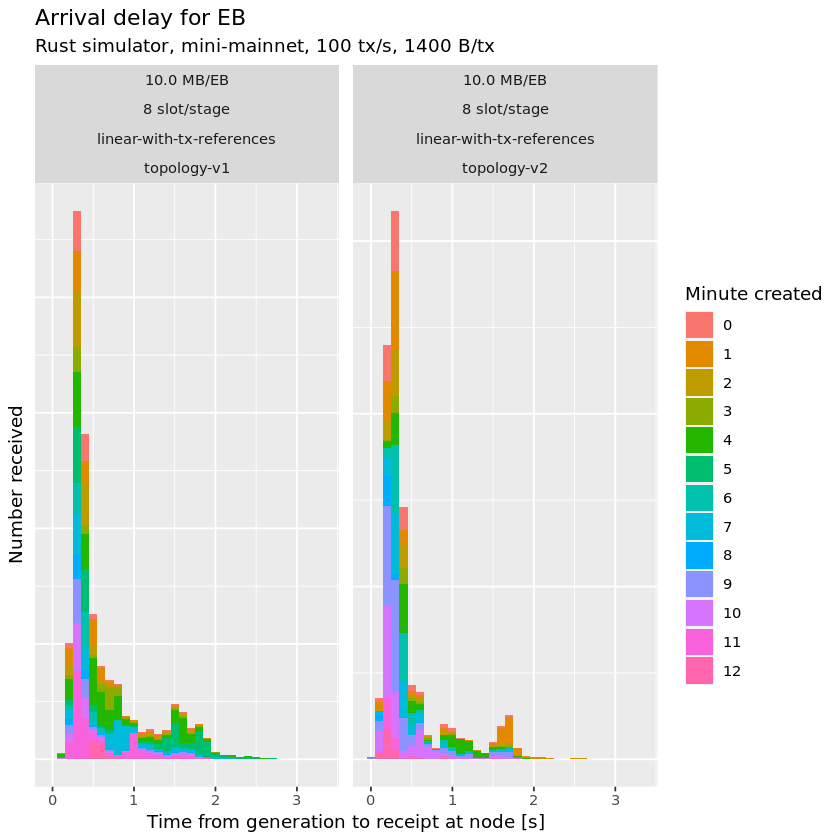

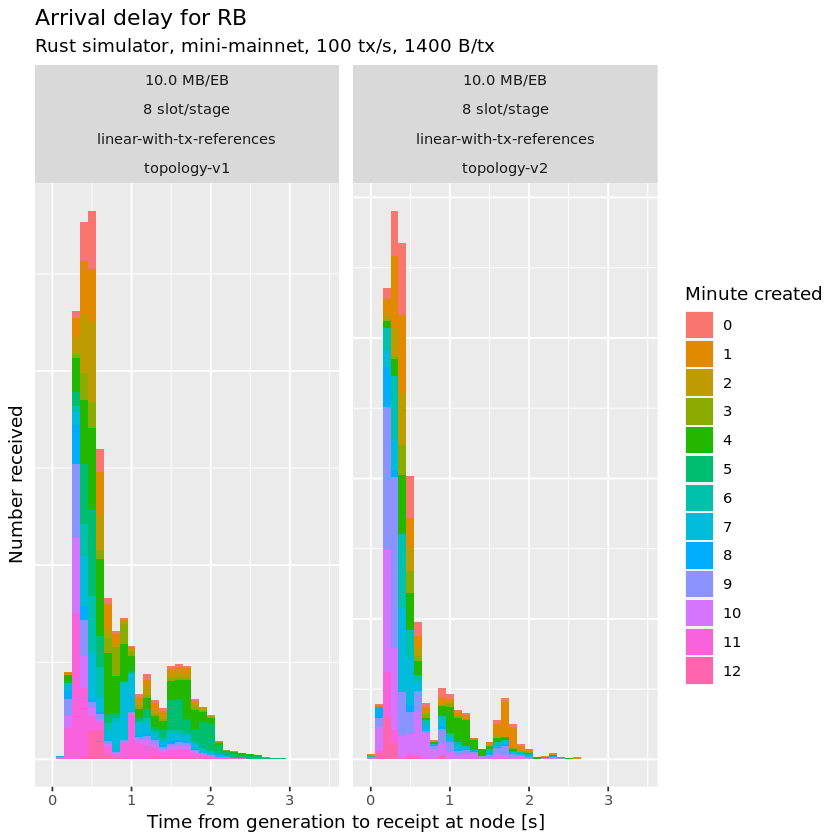

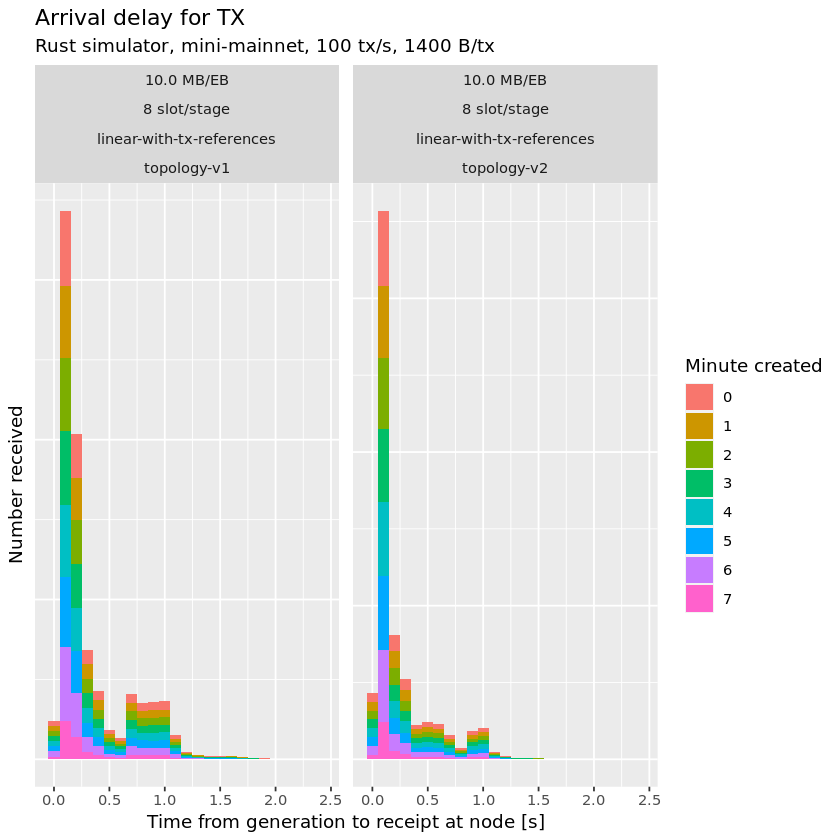

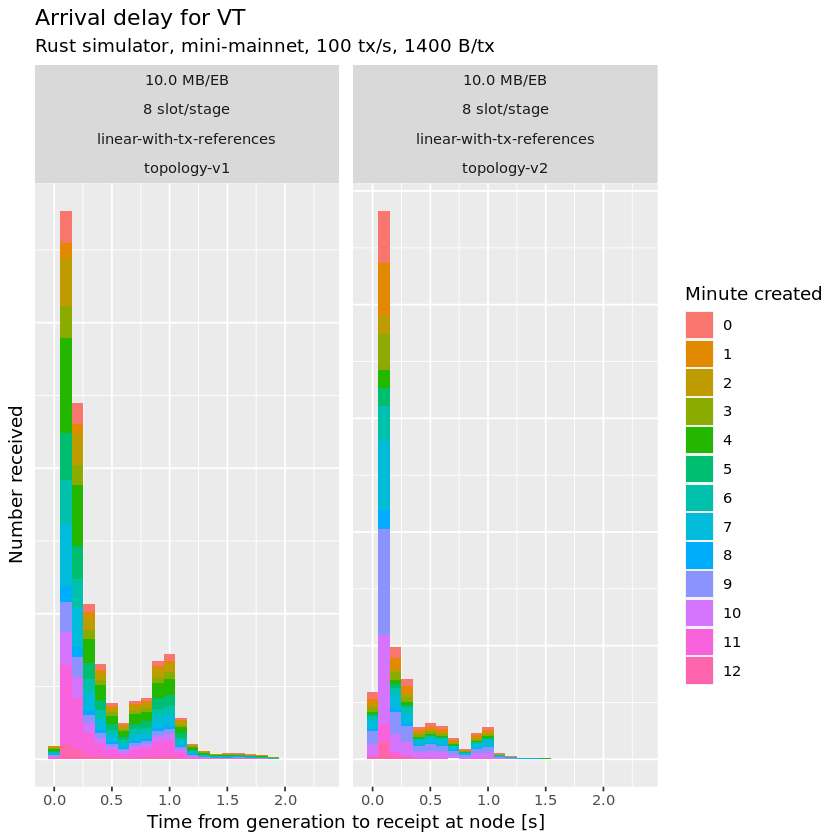

In [45]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [46]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_wrap(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales=scales, ncol=2) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

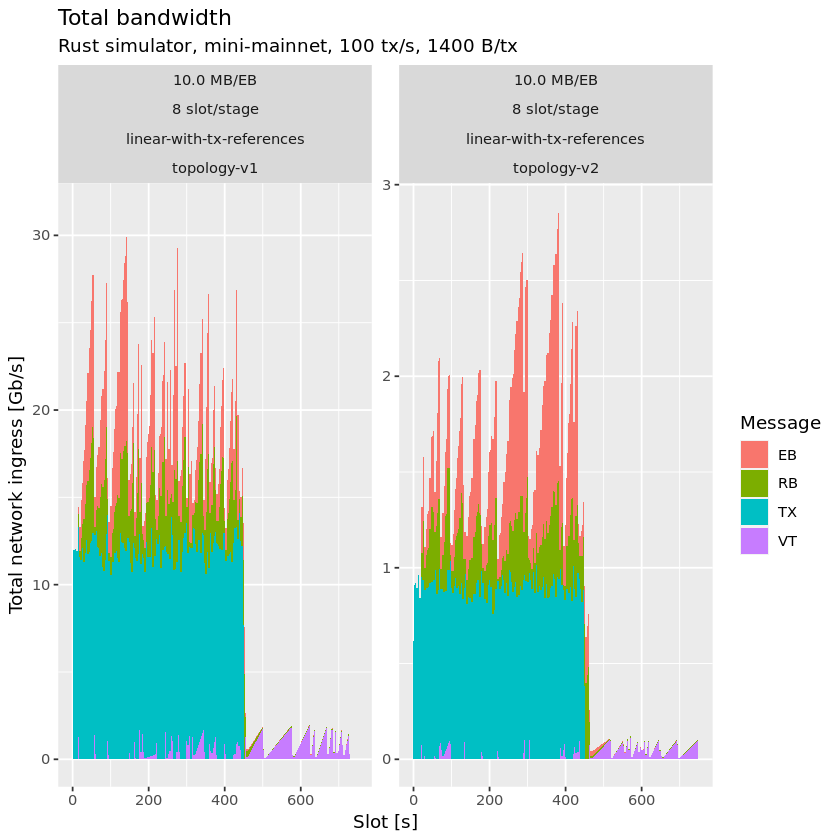

In [47]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [48]:
nodeCount <- receipts[, length(unique(`Recipient`)), .(`Network`)]
nodeCount

Network,V1
<fct>,<int>
topology-v2,750
topology-v1,10000


In [49]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6/ifelse(`Network`=="topology-v1",10000,750)/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_wrap(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales=scales, ncol=2) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

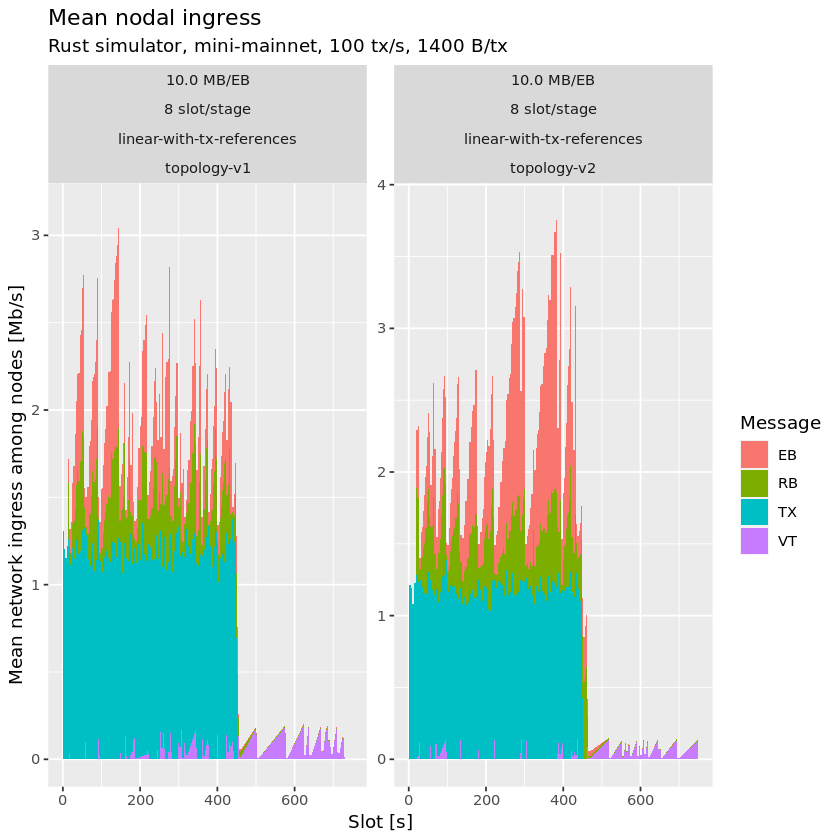

In [50]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="free_y",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [51]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Slot`=floor(`Received [s]`), `Message`=`Kind`, `Recipient`)
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

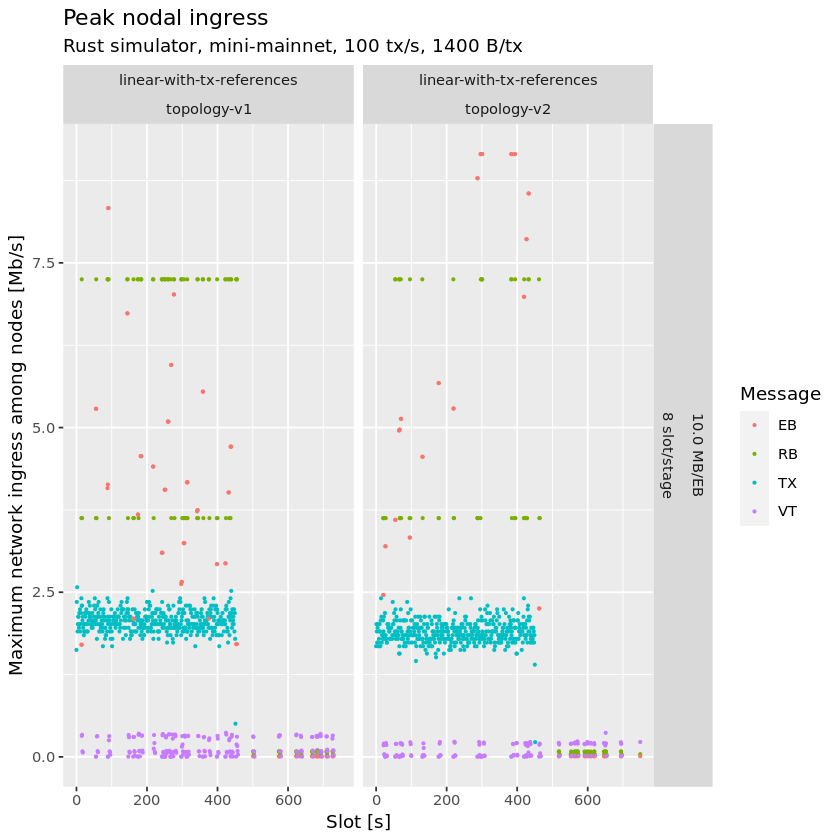

In [52]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

#### Release memory

In [53]:
rm(receipts)

In [54]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1090582,58.3,2036090,108.8,2036090,108.8
Vcells,1025139989,7821.2,2918550819,22266.8,4560235653,34791.9


### CPU usage

#### Read results

In [55]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(cpus, file="results/cpus.Rdata")
}
cpus[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
cpus %>% summary

Loaded Rdata file: sampleSize = 0.2 


 Simulator                             Variant         
 Rust:120533545   linear-with-tx-references:120533545  
                                                       
                                                       
                                                       
                                                       
                                                       
                                                       
        Stage length           Max EB size               Network         
 5 slot/stage :        0   10.0 MB/EB:120533545   topology-v1:112856876  
 8 slot/stage :120533545   50.0 MB/EB:        0   topology-v2:  7676669  
 15 slot/stage:        0   20.0 MB/EB:        0                          
                           5.0 MB/EB :        0                          
                           2.0 MB/EB :        0                          
                           1.0 MB/EB :        0                          
                           (Other)

In [56]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Node`, `Slot`)
]

In [57]:
nodeCount <- cpusNode[, length(unique(`Node`)), .(`Network`)]
nodeCount

Network,V1
<fct>,<int>
topology-v2,750
topology-v1,10000


#### Peak CPU usage

##### Histogram

In [58]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

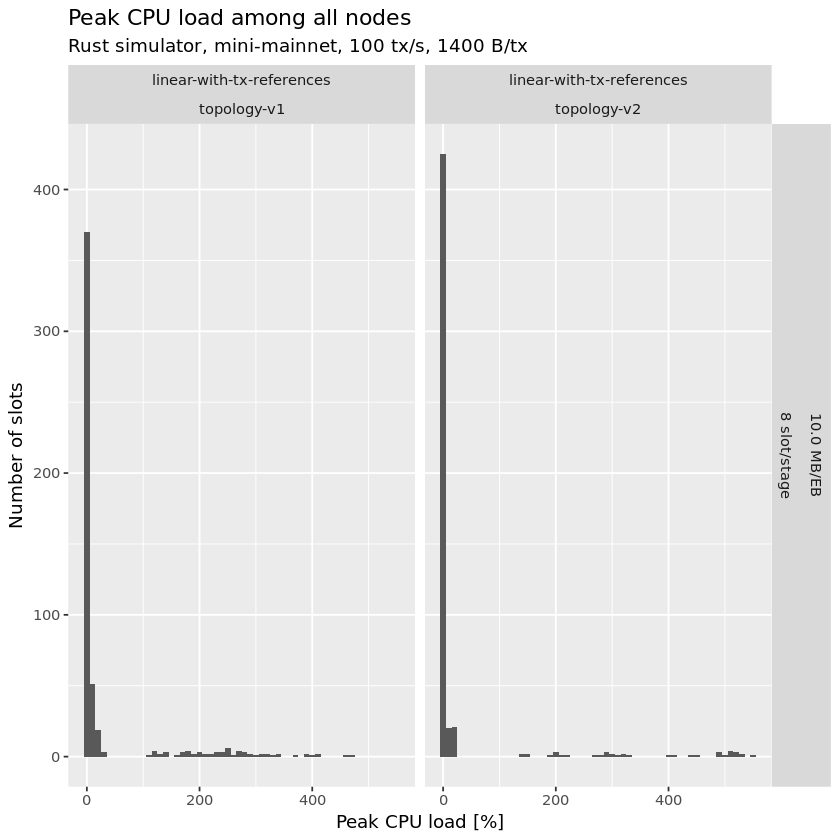

In [59]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [60]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scale=scales) +
#       scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

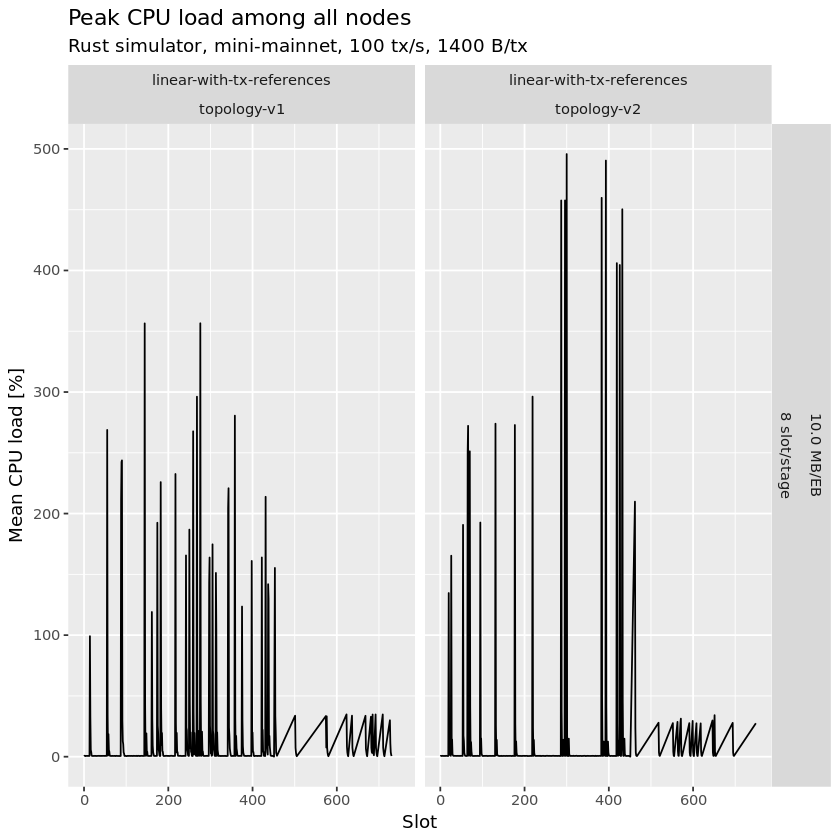

In [61]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [62]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/ifelse(`Network` == "topology-v1", 10000, 750)),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

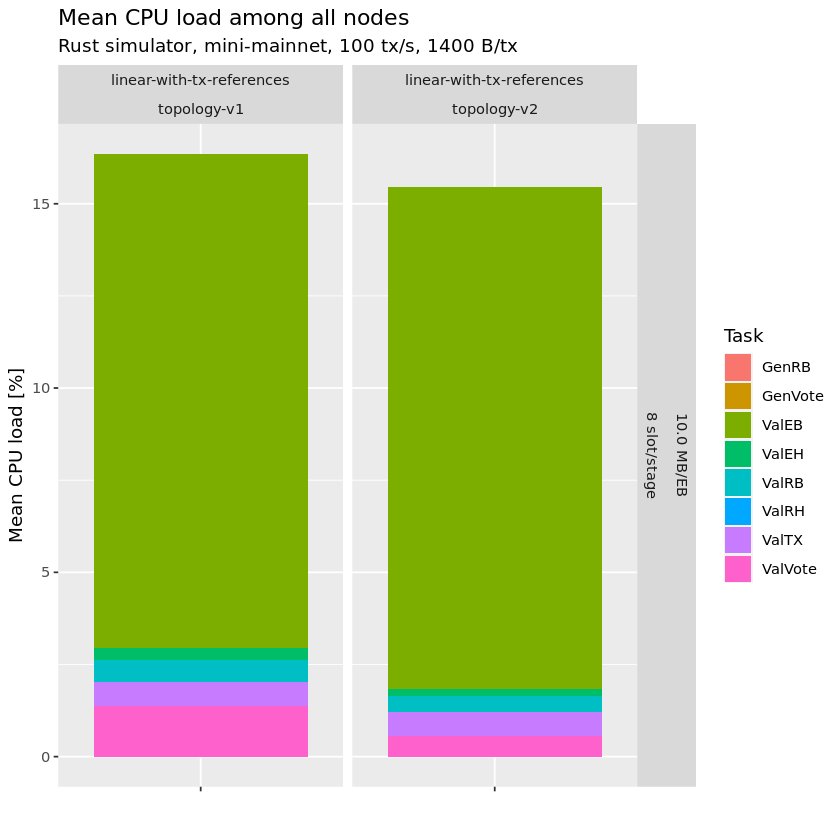

In [63]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [65]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/ifelse(`Network`=="topology-v1",10000,750)/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Network`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

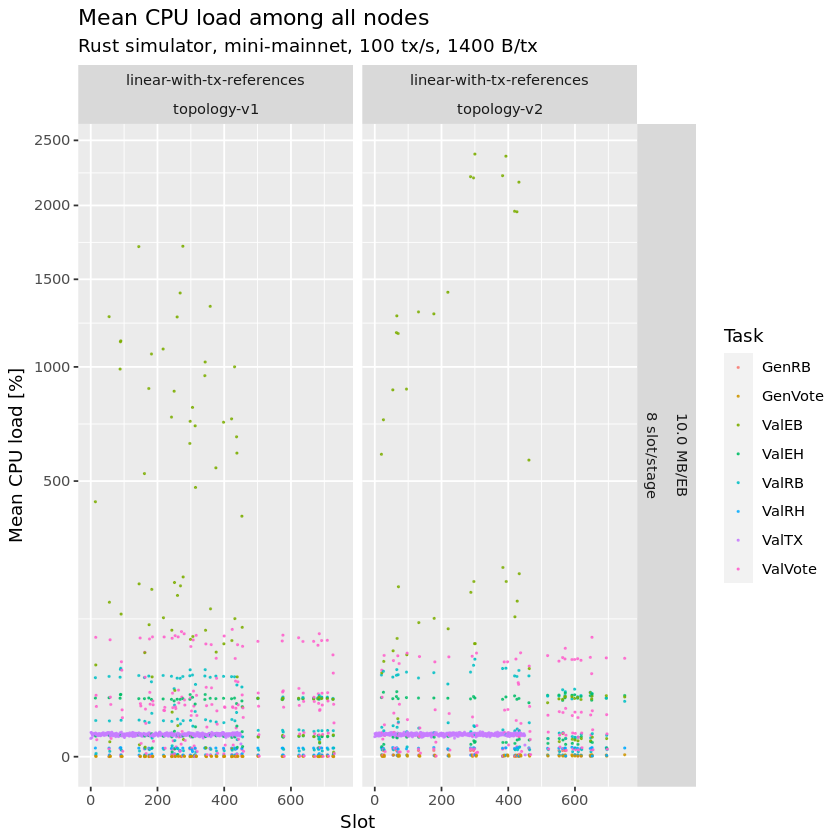

In [66]:
meanCpuTimeseries(
    cpus, 
    sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

#### Release memory

In [67]:
rm(cpus, cpusNode)

In [68]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1032436,55.2,2036090,108.8,2036090,108.8
Vcells,604586700,4612.7,2334840656,17813.5,4560235653,34791.9


## Block contents

### Read data

In [69]:
sizes <- fread("sizes.csv", stringsAsFactors=TRUE)
sizes[, `Max EB size`:=factor(`Max EB size`, levels=c("20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB"))]
sizes %>% summary

 Simulator                       Variant          Stage length     Max EB size 
 Rust:144   linear-with-tx-references:144   8 slot/stage:144   20.0 MB/EB:  0  
                                                               10.0 MB/EB:144  
                                                               5.0 MB/EB :  0  
                                                                               
                                                                               
                                                                               
                                                                               
        Network   Kind               Item     Generated [s]     Transactions 
 topology-v1:78   EB:72   131-node-573 :  2   Min.   : 14.07   Min.   :   0  
 topology-v2:66   RB:72   14-node-7188 :  2   1st Qu.:208.32   1st Qu.:   0  
                          144-node-12  :  2   Median :379.07   Median :  64  
                          161-node-7140:  2   Me

### EB contents

#### Transactions

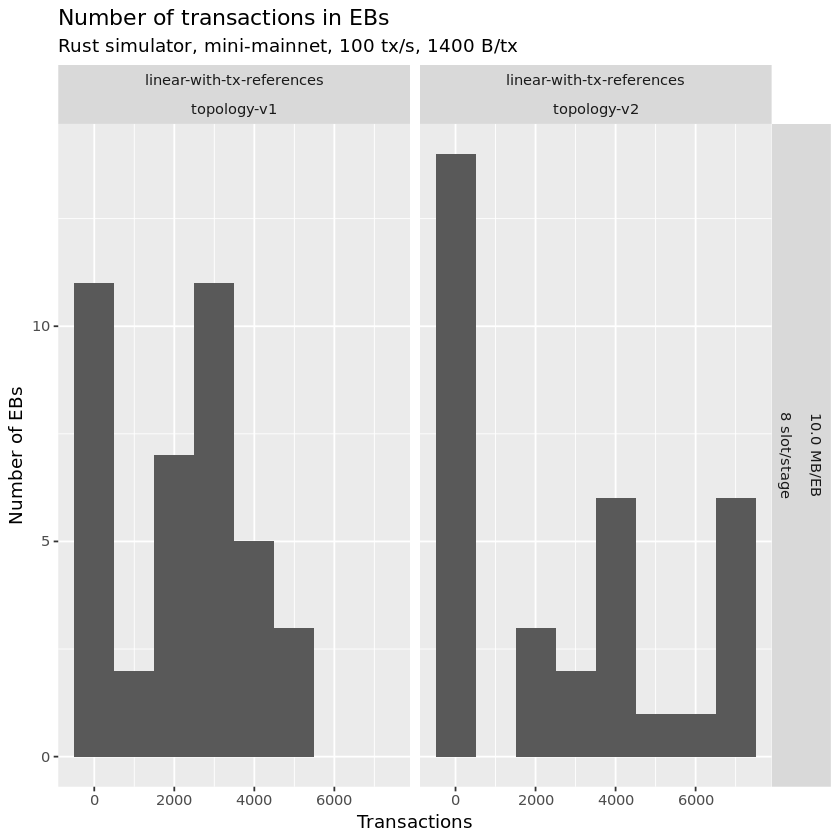

In [70]:
ggplot(sizes[`Kind` == "EB"], aes(x=`Transactions`)) +
    geom_histogram(binwidth=1000) +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ylab("Number of EBs") +
    ggtitle("Number of transactions in EBs", label)

In [71]:
ggsave("plots/contents-ebs-txs.png", units="in", dpi=150, width=16, height=8)

#### Sizes

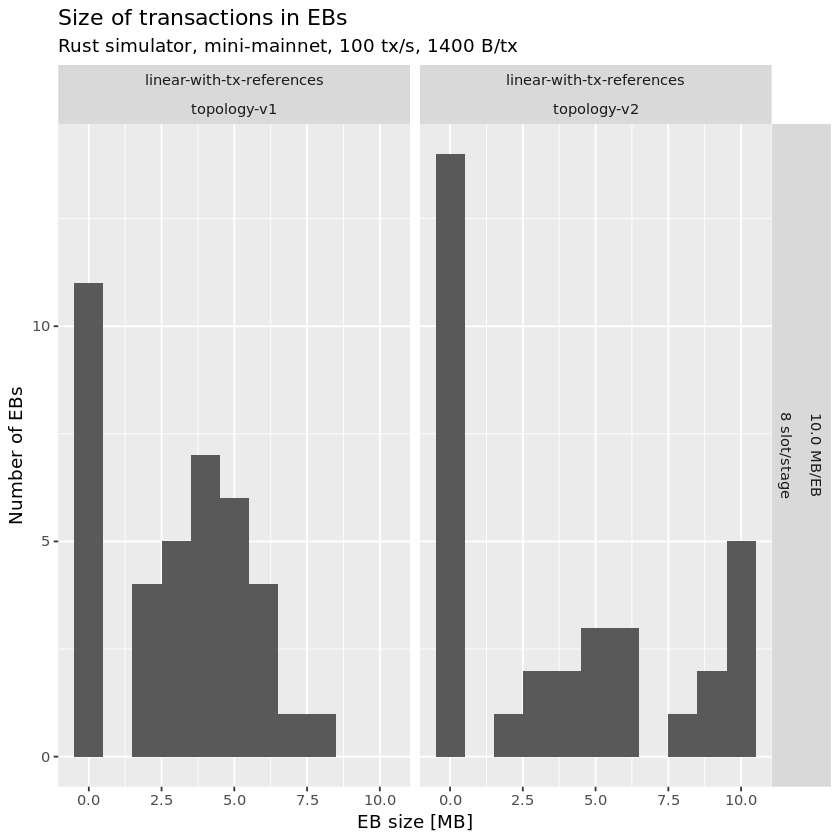

In [72]:
ggplot(sizes[`Kind` == "EB", .(`EB size [MB]`=`Transactions`*1400/1e6), .(`Variant`, `Stage length`, `Max EB size`, `Network`)], aes(x=`EB size [MB]`)) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ylab("Number of EBs") +
    ggtitle("Size of transactions in EBs", label)

In [73]:
ggsave("plots/contents-ebs-size.png", units="in", dpi=150, width=16, height=8)

### RB contents

#### Transactions

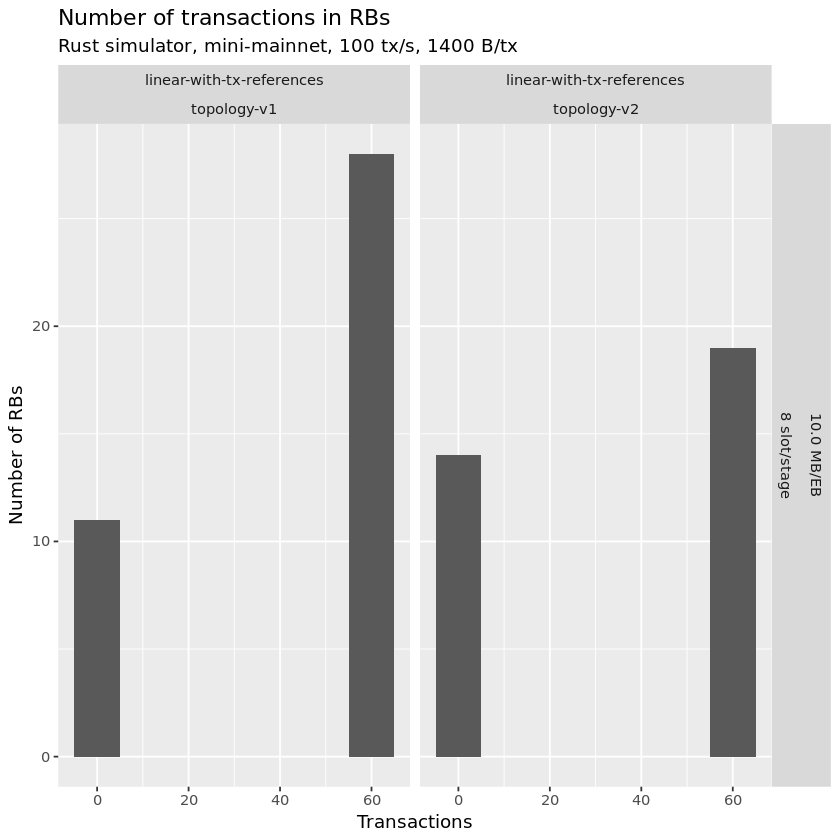

In [74]:
ggplot(sizes[`Kind` == "RB"], aes(x=`Transactions`)) +
    geom_histogram(binwidth=10) +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ylab("Number of RBs") +
    ggtitle("Number of transactions in RBs", label)

In [75]:
ggsave("plots/contents-rbs-txs.png", units="in", dpi=150, width=16, height=8)

#### Sizes

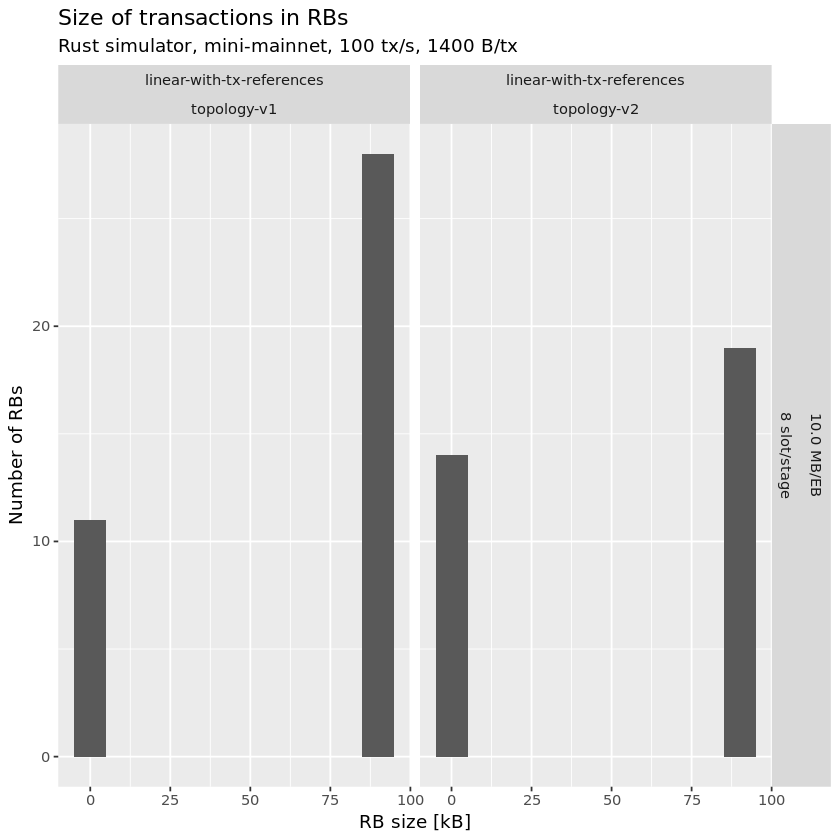

In [76]:
ggplot(sizes[`Kind` == "RB", .(`RB size [kB]`=`Transactions`*1400/1e3), .(`Variant`, `Stage length`, `Max EB size`, `Network`)], aes(x=`RB size [kB]`)) +
    geom_histogram(binwidth=10) +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ylab("Number of RBs") +
    ggtitle("Size of transactions in RBs", label)

In [77]:
ggsave("plots/contents-rbs-size.png", units="in", dpi=150, width=16, height=8)

### Disposition of blocks

#### Data processing

In [78]:
ebSizes <- sizes[`Kind` == "RB" & !is.na(`Endorses`), .(`Certified`=TRUE), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Item`=`Endorses`)][
    sizes[`Kind` == "EB", .(`EB Transactions`=`Transactions`), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Item`)], 
    on=c("Variant", "Stage length", "Max EB size", "Network", "Item")
][
    ,
    .(
        `EB txs later not certified`=ifelse(is.na(`Certified`), as.numeric(`EB Transactions`), 0),
        `EB txs later certified`=ifelse(is.na(`Certified`), 0, as.numeric(`EB Transactions`))
    ),
    .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Item`)
][`Variant` != "full-without-ibs"]

In [79]:
rbSizes <- ebSizes[
    ebSizes[, .(`EB txs certified now`=`EB txs later certified`), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Endorses`=`Item`)][
        sizes[`Kind` == "RB", .(`Generated [s]`, `RB Transactions`=as.numeric(`Transactions`)), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Item`, `Endorses`)],
        on=c("Variant", "Stage length", "Max EB size", "Network", "Endorses")
    ],
    on=c("Variant", "Stage length", "Max EB size", "Network", "Item")
][
    ,
    .(
        `Generated [s]`,
        `RB`=`RB Transactions`,
        `EB later not certified`=`EB txs later not certified`,
        `EB later certified`=`EB txs later certified`,
        `EB now certified`=ifelse(is.na(`EB txs certified now`), 0, `EB txs certified now`)
    ),
    , .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Item`)
][`Variant` != "full-without-ibs"]

In [80]:
blocks <- melt(
    rbSizes, 
    id.vars=c("Variant", "Stage length", "Max EB size", "Network", "Item", "Generated [s]"),
    measure.vars=c("RB", "EB later not certified", "EB later certified", "EB now certified"),
    variable.name="Block",
    value.name="Transactions"
)

#### Sanity checks

In [81]:
ebSizes[, .N] == sizes[`Variant` != "full-without-ibs" & `Kind` == "EB", .N]

[1] TRUE

In [82]:
ebSizes[, sum(`EB txs later not certified`) + sum(`EB txs later certified`)] == sizes[`Variant` != "full-without-ibs" &`Kind` == "EB", sum(`Transactions`)]

[1] TRUE

In [83]:
rbSizes[, .N] == sizes[`Variant` != "full-without-ibs" & `Kind` == "RB", .N]

[1] TRUE

In [84]:
rbSizes[, sum(`RB`)] == sizes[`Variant` != "full-without-ibs" & `Kind` == "RB", sum(`Transactions`)]

[1] TRUE

In [85]:
rbSizes[, sum(`EB later not certified`) + sum(`EB later certified`)] == sizes[`Variant` != "full-without-ibs" & `Kind` == "EB", sum(`Transactions`)]

[1] TRUE

In [86]:
# TODO: Compute precise equality that accounts for forks.
rbSizes[, sum(`EB later certified`)] <= rbSizes[, sum(`EB now certified`)]

[1] TRUE

#### Transactions

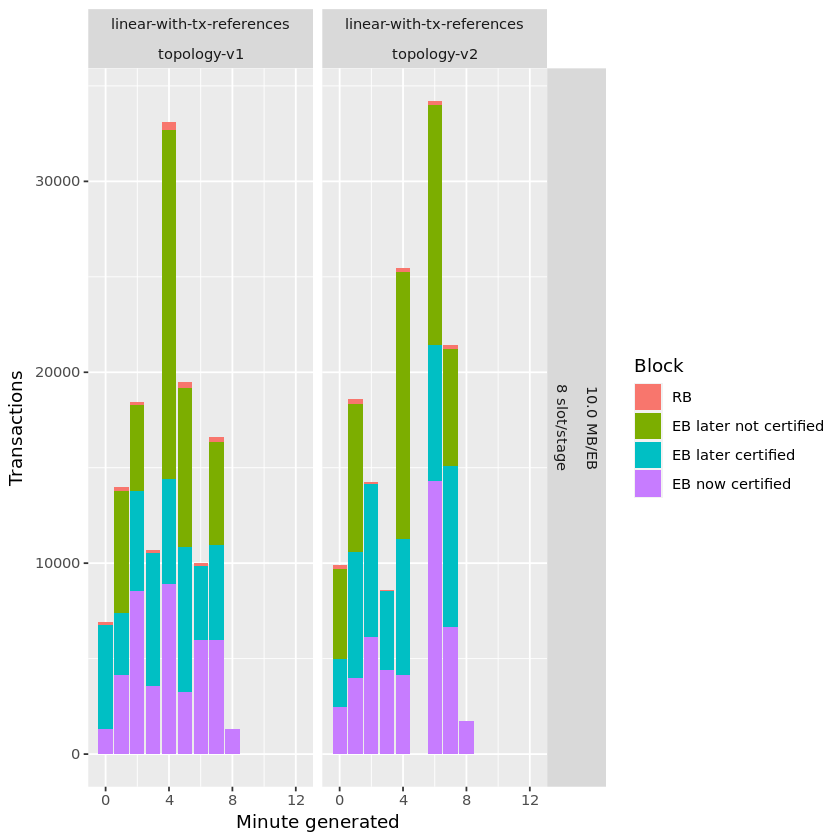

In [87]:
ggplot(
    blocks[, .(`Transactions`=sum(`Transactions`)), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Block`, `Minute generated`=(floor(`Generated [s]`/60)))], 
    aes(x=`Minute generated`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`)

In [88]:
ggsave("plots/disposition-txs-timeseries.png", units="in", dpi=150, width=16, height=8)

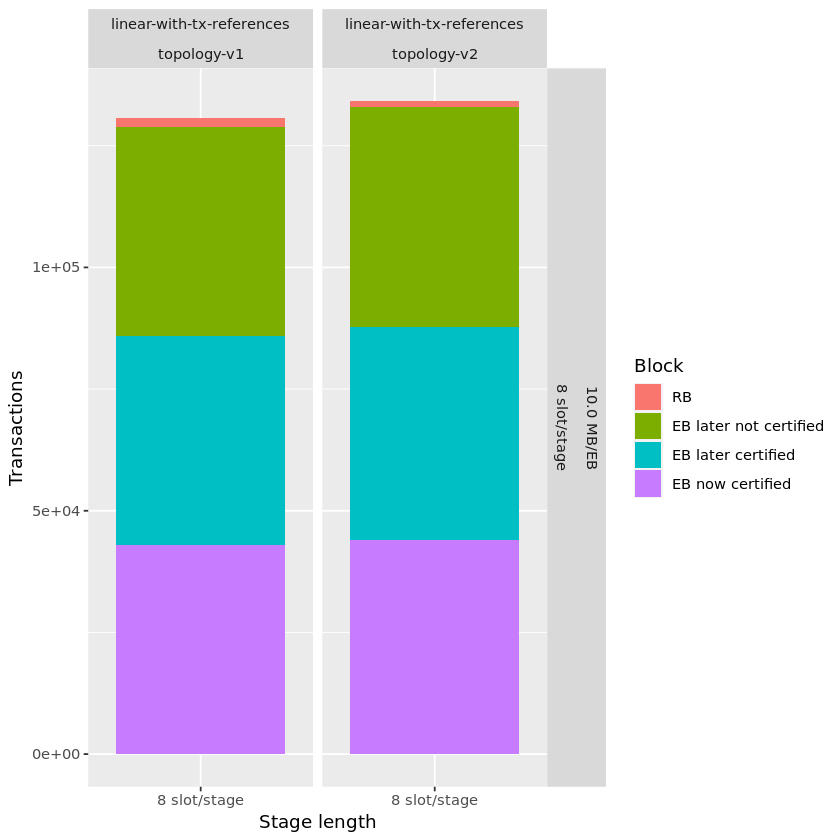

In [89]:
ggplot(
    blocks[, .(`Transactions`=sum(`Transactions`)), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Block`)], 
    aes(x=`Stage length`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`)

In [90]:
ggsave("plots/disposition-txs-histogram.png", units="in", dpi=150, width=16, height=8)

#### Sizes

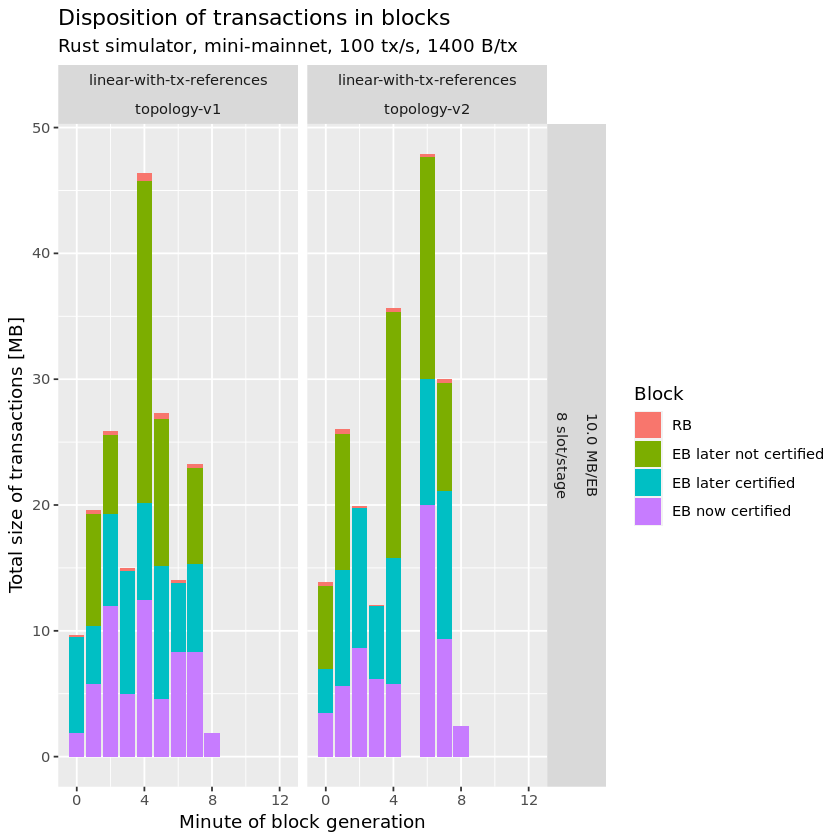

In [91]:
ggplot(
    blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*1400/1e6), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Block`, `Minute of block generation`=(floor(`Generated [s]`/60)))], 
    aes(x=`Minute of block generation`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ggtitle("Disposition of transactions in blocks", label)

In [92]:
ggsave("plots/disposition-size-timeseries.png", units="in", dpi=150, width=16, height=8)

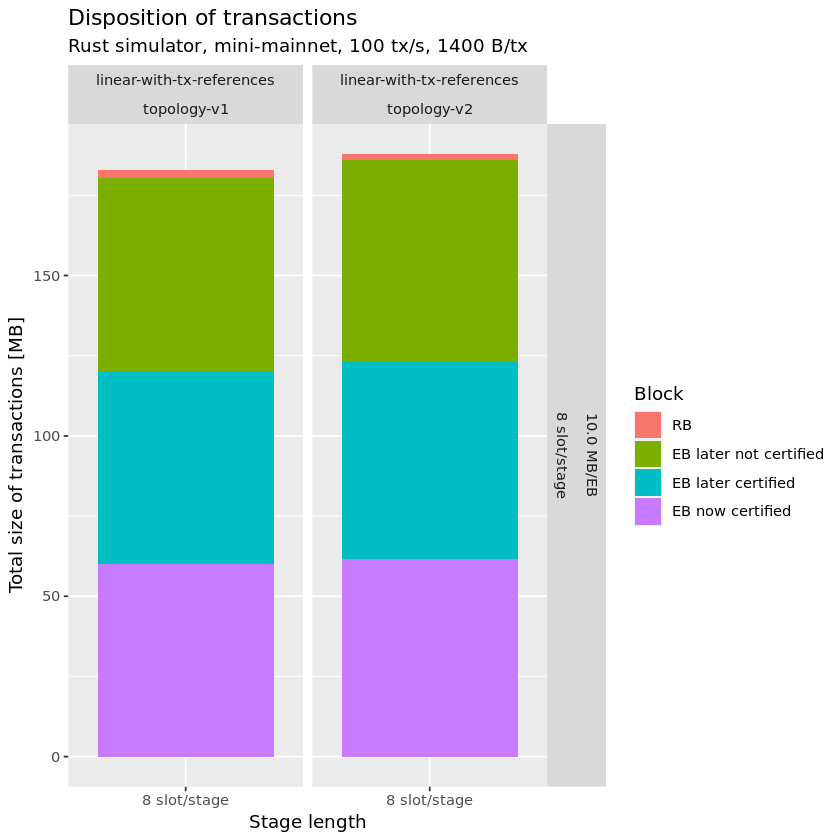

In [93]:
ggplot(
    blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*1400/1e6), .(`Variant`, `Stage length`, `Max EB size`, `Network`, `Block`)], 
    aes(x=`Stage length`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` + `Stage length` ~ `Variant` + `Network`) +
    ggtitle("Disposition of transactions", label)

In [94]:
ggsave("plots/disposition-size-histogram.png", units="in", dpi=150, width=16, height=8)